In [3]:
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
import pyttsx3
import time

# Initialize TTS
engine = pyttsx3.init()
engine.setProperty('rate', 150)

# Load model
model = load_model("sign_language_model.h5")

# Parameters
IMG_SIZE = 64
confidence_threshold = 0.6
turn_duration = 10  # seconds per turn

# Mediapipe Hands
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(False, max_num_hands=1, min_detection_confidence=0.7)

# Webcam
cap = cv2.VideoCapture(0)

# Class Labels
class_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F',
                6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L',
                12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
                18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X',
                24: 'Y', 25: 'Z', 26: ' ', 27: '0', 28: '1', 29: '2',
                30: '3', 31: '4', 32: '5', 33: '6', 34: '7', 35: '8', 36: '9'}

def recognize_sign():
    detected_text = []
    last_letter = None
    last_time = time.time()
    start_time = time.time()

    while time.time() - start_time < turn_duration:
        ret, frame = cap.read()
        if not ret:
            break
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = hands.process(rgb)

        if result.multi_hand_landmarks:
            for hand_landmarks in result.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                x_min = min([int(lm.x * frame.shape[1]) for lm in hand_landmarks.landmark])
                y_min = min([int(lm.y * frame.shape[0]) for lm in hand_landmarks.landmark])
                x_max = max([int(lm.x * frame.shape[1]) for lm in hand_landmarks.landmark])
                y_max = max([int(lm.y * frame.shape[0]) for lm in hand_landmarks.landmark])

                padding = 20
                x_min, y_min = max(x_min - padding, 0), max(y_min - padding, 0)
                x_max, y_max = min(x_max + padding, frame.shape[1]), min(y_max + padding, frame.shape[0])

                hand_img = frame[y_min:y_max, x_min:x_max]
                if hand_img.size > 0:
                    hand_img = cv2.resize(hand_img, (IMG_SIZE, IMG_SIZE))
                    hand_img = hand_img / 255.0
                    hand_img = np.expand_dims(hand_img, axis=0)

                    prediction = model.predict(hand_img)
                    if np.max(prediction) > confidence_threshold:
                        predicted_class = np.argmax(prediction)
                        letter = class_labels.get(predicted_class, '?')
                        if letter != last_letter or (time.time() - last_time) > 1.5:
                            detected_text.append(letter)
                            last_letter = letter
                            last_time = time.time()

        formatted_text = "".join(detected_text).strip()
        cv2.putText(frame, f"Signer: {formatted_text}", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imshow("Sign-to-Text", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    return "".join(detected_text).strip()

print("\n🔄 Starting conversation... Press 'q' to quit anytime.")

while True:
    print("\n🧤 Signer's Turn (10s)...")
    signer_text = recognize_sign()
    if signer_text:
        print("Signer 🧤:", signer_text)
    else:
        print("No sign detected.")

    print("\n🗣️ Speaker's Turn: Type your response")
    speaker_text = input("Speaker 💬: ")
    engine.say(speaker_text)
    engine.runAndWait()

cap.release()
cv2.destroyAllWindows()


🔄 Starting conversation... Press 'q' to quit anytime.

🧤 Signer's Turn (10s)...
No sign detected.

🗣️ Speaker's Turn: Type your response
Speaker 💬: Hey how can you?

🧤 Signer's Turn (10s)...
1/1 [==============================] - 0s 24ms/step
Signer 🧤: PQ

🗣️ Speaker's Turn: Type your response
Speaker 💬: im good how are you?

🧤 Signer's Turn (10s)...
1/1 [==============================] - 0s 24ms/step
No sign detected.

🗣️ Speaker's Turn: Type your response
Speaker 💬: q

🧤 Signer's Turn (10s)...
1/1 [==============================] - 0s 32ms/step
No sign detected.

🗣️ Speaker's Turn: Type your response


KeyboardInterrupt: Interrupted by user


📘 Word: HELLO


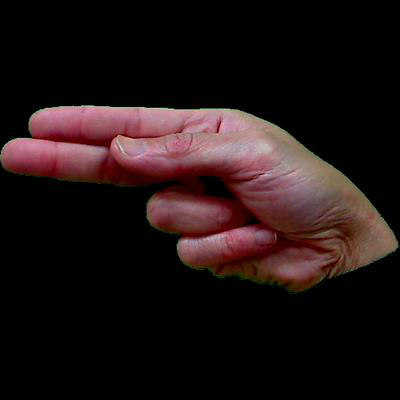

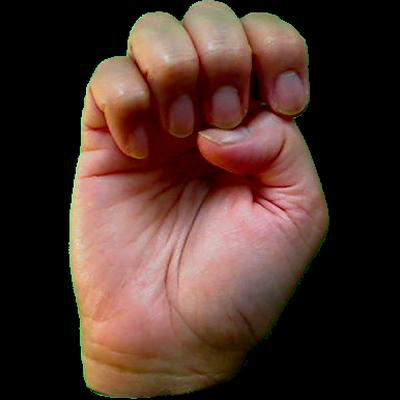

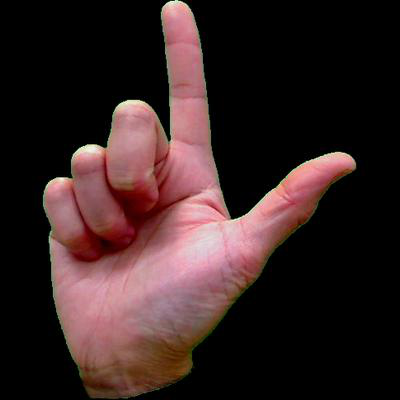

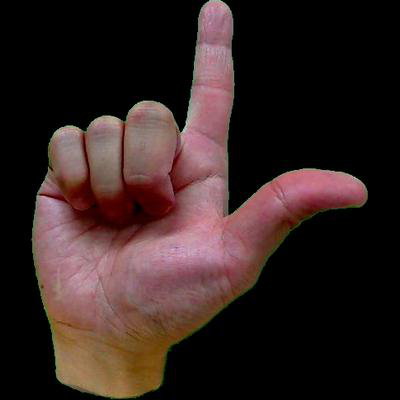

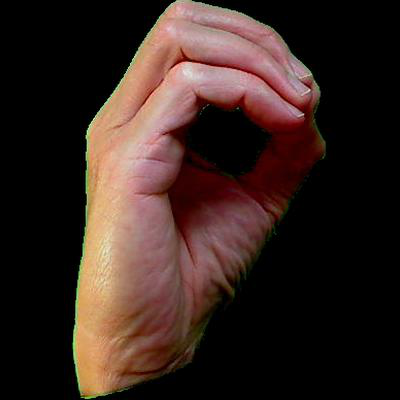


📘 Word: HELLO


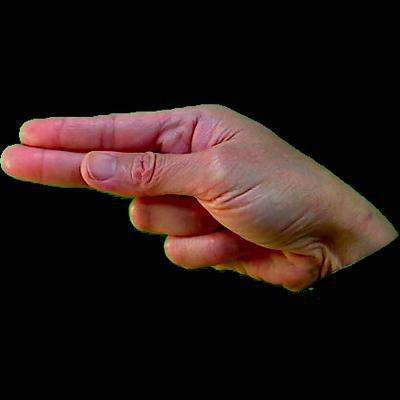

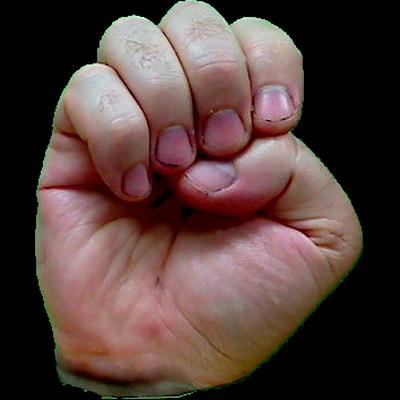

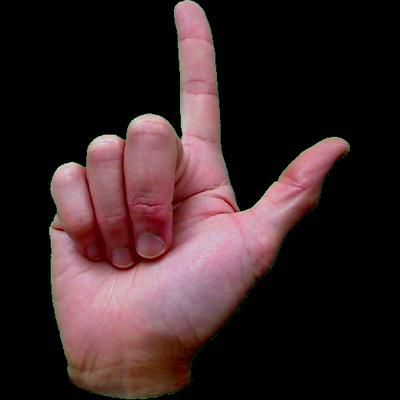

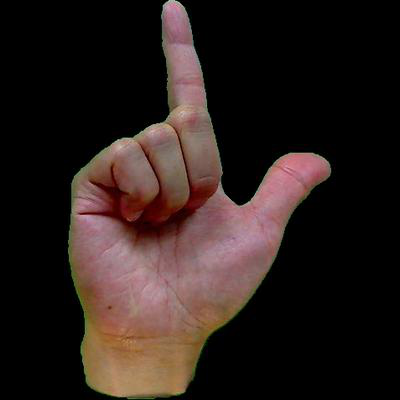

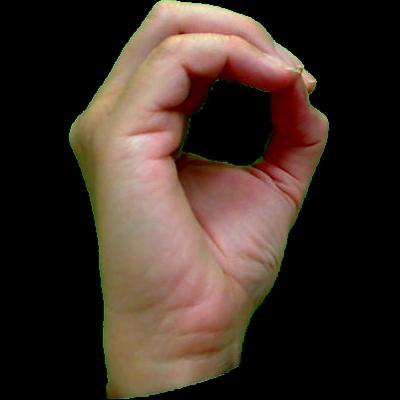


📘 Word: HELLO


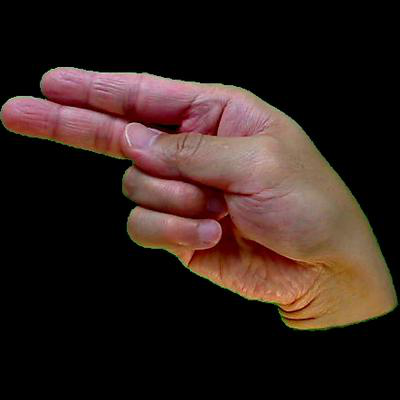

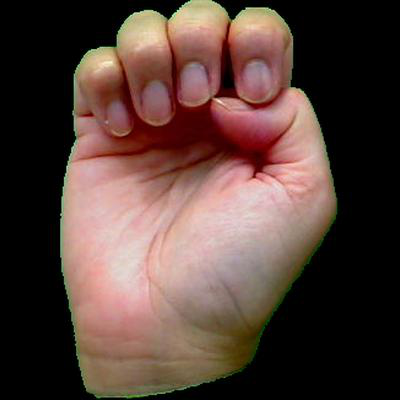

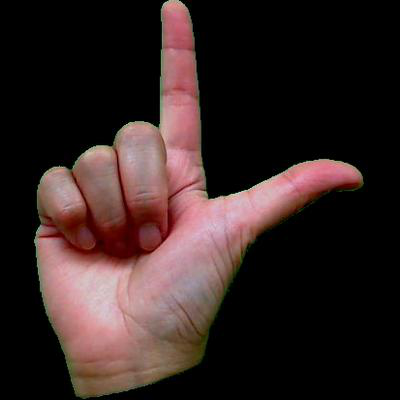

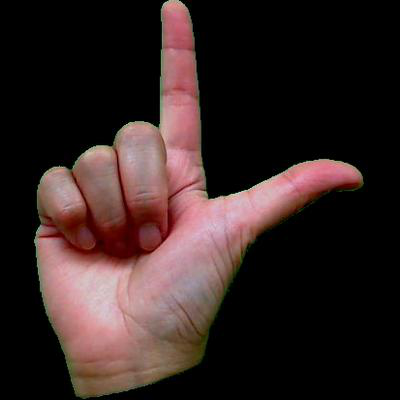

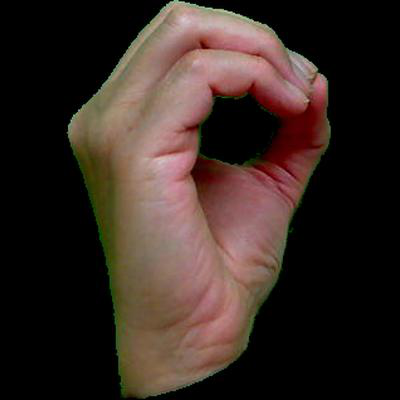


🧤 Signer's Turn (10s)...
1/1 [==============================] - 0s 23ms/step
⚠️ No sign detected.

🗣️ Speaker's Turn...

🎤 Speaker: Speak something...
⚠️ Could not understand audio.
⚠️ Could not process speaker input.

🧤 Signer's Turn (10s)...
⚠️ No sign detected.

🗣️ Speaker's Turn...

🎤 Speaker: Speak something...
⚠️ Could not understand audio.
⚠️ Could not process speaker input.

🧤 Signer's Turn (10s)...


KeyboardInterrupt: 

In [2]:
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
import pyttsx3
import time
import os
import random
import speech_recognition as sr
from PIL import Image as PILImage
from IPython.display import display, clear_output

# ====== Setup Paths ======
SIGN_LANGUAGE_IMG_PATH = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 2/asl_dataset/"

# ====== TTS Setup ======
engine = pyttsx3.init()
engine.setProperty('rate', 150)

# ====== Load Trained Model ======
model = load_model("sign_language_model.h5")

# ====== Mediapipe Setup ======
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.7
)

# ====== Webcam ======
cap = cv2.VideoCapture(0)

# ====== Label Mapping ======
class_labels = {i: chr(65+i) for i in range(26)}
class_labels[26] = ' '

# ====== Parameters ======
IMG_SIZE = 64
confidence_threshold = 0.6
turn_duration = 10  # seconds

# ====== Show Sign Images for Text (Word-wise) ======
def show_sign_images(text):
    words = text.strip().upper().split()
    for word in words:
        print(f"\n📘 Word: {word}")
        for letter in word:
            folder_path = os.path.join(SIGN_LANGUAGE_IMG_PATH, letter)
            if os.path.exists(folder_path):
                images = os.listdir(folder_path)
                if images:
                    img_path = os.path.join(folder_path, random.choice(images))
                    img = PILImage.open(img_path)
                    display(img)
                    time.sleep(0.3)  # Delay between letters
                else:
                    print(f"⚠️ No images in folder: {letter}")
            else:
                print(f"⚠️ Folder for letter {letter} not found.")
        time.sleep(0.5)  # Delay between words

# ====== Recognize Sign from Webcam ======
def recognize_sign():
    detected_text = []
    last_letter = None
    last_time = time.time()
    start_time = time.time()

    while time.time() - start_time < turn_duration:
        ret, frame = cap.read()
        if not ret:
            break
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = hands.process(rgb)

        if result.multi_hand_landmarks:
            for hand_landmarks in result.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                x_min = min([int(lm.x * frame.shape[1]) for lm in hand_landmarks.landmark])
                y_min = min([int(lm.y * frame.shape[0]) for lm in hand_landmarks.landmark])
                x_max = max([int(lm.x * frame.shape[1]) for lm in hand_landmarks.landmark])
                y_max = max([int(lm.y * frame.shape[0]) for lm in hand_landmarks.landmark])

                padding = 20
                x_min, y_min = max(x_min - padding, 0), max(y_min - padding, 0)
                x_max, y_max = min(x_max + padding, frame.shape[1]), min(y_max + padding, frame.shape[0])

                hand_img = frame[y_min:y_max, x_min:x_max]
                if hand_img.size > 0:
                    hand_img = cv2.resize(hand_img, (IMG_SIZE, IMG_SIZE))
                    hand_img = hand_img / 255.0
                    hand_img = np.expand_dims(hand_img, axis=0)

                    prediction = model.predict(hand_img)
                    if np.max(prediction) > confidence_threshold:
                        predicted_class = np.argmax(prediction)
                        letter = class_labels.get(predicted_class, '?')
                        if letter != last_letter or (time.time() - last_time) > 1.5:
                            detected_text.append(letter)
                            last_letter = letter
                            last_time = time.time()

        formatted_text = "".join(detected_text).strip()
        cv2.putText(frame, f"Signer: {formatted_text}", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imshow("Sign-to-Text", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    return "".join(detected_text).strip()

# ====== Speech Recognition for Speaker ======
def recognize_speech():
    recognizer = sr.Recognizer()
    with sr.Microphone() as source:
        print("\n🎤 Speaker: Speak something...")
        recognizer.adjust_for_ambient_noise(source)
        try:
            audio = recognizer.listen(source, timeout=5)
            text = recognizer.recognize_google(audio)
            print(f"📝 Transcribed Text: {text}")
            return text
        except sr.UnknownValueError:
            print("⚠️ Could not understand audio.")
        except sr.RequestError:
            print("⚠️ Request error. Check internet.")
        except sr.WaitTimeoutError:
            print("⚠️ No speech detected.")
    return None

# ====== Main Loop ======
print("\n🔁 Starting Sign-Speech Conversation (press 'q' to quit)...")

while True:
    # Signer's Turn
    print("\n🧤 Signer's Turn (10s)...")
    signer_text = recognize_sign()
    if signer_text:
        print("🧤 Signer:", signer_text)
    else:
        print("⚠️ No sign detected.")

    # Speaker's Turn
    print("\n🗣️ Speaker's Turn...")
    speaker_text = recognize_speech()
    if speaker_text:
        print("💬 Speaker:", speaker_text)
        engine.say(speaker_text)
        engine.runAndWait()

        # Show sign language representation
        print("\n📷 Converting to sign language...")
        clear_output(wait=True)
        show_sign_images(speaker_text)
    else:
        print("⚠️ Could not process speaker input.")

    # Exit option
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release Resources
cap.release()
cv2.destroyAllWindows()

In [9]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "sign_language_model.h5"
CLASS_NAMES_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names from directory names ---
class_names = sorted([d for d in os.listdir(CLASS_NAMES_DIR) if os.path.isdir(os.path.join(CLASS_NAMES_DIR, d))])

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming filename like A_001.jpg

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label.upper() == predicted_label.upper()
        correct += int(is_correct)
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

ValueError: in user code:

    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(None, 128, 128, 3)


In [5]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "sign_language_modelv2.h5"
CLASS_NAMES_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names from directory names ---
class_names = sorted([d for d in os.listdir(CLASS_NAMES_DIR) if os.path.isdir(os.path.join(CLASS_NAMES_DIR, d))])

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming filename like A_001.jpg

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label.upper() == predicted_label.upper()
        correct += int(is_correct)
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

ValueError: in user code:

    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 64, 64, 1), found shape=(None, 128, 128, 3)


In [10]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "sign_language_modelv3.h5"
CLASS_NAMES_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names from directory names ---
class_names = sorted([d for d in os.listdir(CLASS_NAMES_DIR) if os.path.isdir(os.path.join(CLASS_NAMES_DIR, d))])

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming filename like A_001.jpg

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label.upper() == predicted_label.upper()
        correct += int(is_correct)
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

ValueError: in user code:

    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 64, 64, 1), found shape=(None, 128, 128, 3)


In [11]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "sign_language_modelv4.h5"
CLASS_NAMES_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names from directory names ---
class_names = sorted([d for d in os.listdir(CLASS_NAMES_DIR) if os.path.isdir(os.path.join(CLASS_NAMES_DIR, d))])

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming filename like A_001.jpg

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label.upper() == predicted_label.upper()
        correct += int(is_correct)
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

ValueError: in user code:

    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(None, 128, 128, 3)


In [12]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "sign_language_modelv5.h5"
CLASS_NAMES_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names from directory names ---
class_names = sorted([d for d in os.listdir(CLASS_NAMES_DIR) if os.path.isdir(os.path.join(CLASS_NAMES_DIR, d))])

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming filename like A_001.jpg

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label.upper() == predicted_label.upper()
        correct += int(is_correct)
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

ValueError: in user code:

    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(None, 128, 128, 3)


In [15]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "sign_language_modelv6.h5"
CLASS_NAMES_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names from directory names ---
class_names = sorted([d for d in os.listdir(CLASS_NAMES_DIR) if os.path.isdir(os.path.join(CLASS_NAMES_DIR, d))])

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming filename like A_001.jpg

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label.upper() == predicted_label.upper()
        correct += int(is_correct)
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

🖼️ 0_test.jpg | ✅ Expected: 0 | 🔮 Predicted: C | ❌
🖼️ 1_test.jpg | ✅ Expected: 1 | 🔮 Predicted: C | ❌
🖼️ 2_test.jpg | ✅ Expected: 2 | 🔮 Predicted: 5 | ❌
🖼️ 3_test.jpg | ✅ Expected: 3 | 🔮 Predicted: 5 | ❌
🖼️ 4_test.jpg | ✅ Expected: 4 | 🔮 Predicted: 5 | ❌
🖼️ 5_test.jpg | ✅ Expected: 5 | 🔮 Predicted: 4 | ❌
🖼️ 6_test.jpg | ✅ Expected: 6 | 🔮 Predicted: 4 | ❌
🖼️ 7_test.jpg | ✅ Expected: 7 | 🔮 Predicted: 4 | ❌
🖼️ 8_test.jpg | ✅ Expected: 8 | 🔮 Predicted: 5 | ❌
🖼️ 9_test.jpg | ✅ Expected: 9 | 🔮 Predicted: 5 | ❌
🖼️ A_test.jpg | ✅ Expected: A | 🔮 Predicted: C | ❌
🖼️ B_test.jpg | ✅ Expected: B | 🔮 Predicted: 0 | ❌
🖼️ C_test.jpg | ✅ Expected: C | 🔮 Predicted: C | ✔️
🖼️ D_test.jpg | ✅ Expected: D | 🔮 Predicted: 8 | ❌
🖼️ E_test.jpg | ✅ Expected: E | 🔮 Predicted: O | ❌
🖼️ F_test.jpg | ✅ Expected: F | 🔮 Predicted: 5 | ❌
🖼️ G_test.jpg | ✅ Expected: G | 🔮 Predicted: C | ❌
🖼️ H_test.jpg | ✅ Expected: H | 🔮 Predicted: O | ❌
🖼️ I_test.jpg | ✅ Expected: I | 🔮 Predicted: C | ❌
🖼️ J_test.jpg | ✅ Expected: J 

In [14]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "sign_language_modelv7.h5"
CLASS_NAMES_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names from directory names ---
class_names = sorted([d for d in os.listdir(CLASS_NAMES_DIR) if os.path.isdir(os.path.join(CLASS_NAMES_DIR, d))])

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming filename like A_001.jpg

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label.upper() == predicted_label.upper()
        correct += int(is_correct)
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

🖼️ 0_test.jpg | ✅ Expected: 0 | 🔮 Predicted: 0 | ✔️
🖼️ 1_test.jpg | ✅ Expected: 1 | 🔮 Predicted: 1 | ✔️
🖼️ 2_test.jpg | ✅ Expected: 2 | 🔮 Predicted: 2 | ✔️
🖼️ 3_test.jpg | ✅ Expected: 3 | 🔮 Predicted: 3 | ✔️
🖼️ 4_test.jpg | ✅ Expected: 4 | 🔮 Predicted: 4 | ✔️
🖼️ 5_test.jpg | ✅ Expected: 5 | 🔮 Predicted: 5 | ✔️
🖼️ 6_test.jpg | ✅ Expected: 6 | 🔮 Predicted: 6 | ✔️
🖼️ 7_test.jpg | ✅ Expected: 7 | 🔮 Predicted: 7 | ✔️
🖼️ 8_test.jpg | ✅ Expected: 8 | 🔮 Predicted: 8 | ✔️
🖼️ 9_test.jpg | ✅ Expected: 9 | 🔮 Predicted: 9 | ✔️
🖼️ A_test.jpg | ✅ Expected: A | 🔮 Predicted: S | ❌
🖼️ B_test.jpg | ✅ Expected: B | 🔮 Predicted: E | ❌
🖼️ C_test.jpg | ✅ Expected: C | 🔮 Predicted: C | ✔️
🖼️ D_test.jpg | ✅ Expected: D | 🔮 Predicted: O | ❌
🖼️ E_test.jpg | ✅ Expected: E | 🔮 Predicted: E | ✔️
🖼️ F_test.jpg | ✅ Expected: F | 🔮 Predicted: 4 | ❌
🖼️ G_test.jpg | ✅ Expected: G | 🔮 Predicted: G | ✔️
🖼️ H_test.jpg | ✅ Expected: H | 🔮 Predicted: G | ❌
🖼️ I_test.jpg | ✅ Expected: I | 🔮 Predicted: I | ✔️
🖼️ J_test.jpg | ✅

In [16]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "sign_language_modelv8.h5"
CLASS_NAMES_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names from directory names ---
class_names = sorted([d for d in os.listdir(CLASS_NAMES_DIR) if os.path.isdir(os.path.join(CLASS_NAMES_DIR, d))])

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming filename like A_001.jpg

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label.upper() == predicted_label.upper()
        correct += int(is_correct)
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

🖼️ 0_test.jpg | ✅ Expected: 0 | 🔮 Predicted: 0 | ✔️
🖼️ 1_test.jpg | ✅ Expected: 1 | 🔮 Predicted: 1 | ✔️
🖼️ 2_test.jpg | ✅ Expected: 2 | 🔮 Predicted: 2 | ✔️
🖼️ 3_test.jpg | ✅ Expected: 3 | 🔮 Predicted: 3 | ✔️
🖼️ 4_test.jpg | ✅ Expected: 4 | 🔮 Predicted: 4 | ✔️
🖼️ 5_test.jpg | ✅ Expected: 5 | 🔮 Predicted: 4 | ❌
🖼️ 6_test.jpg | ✅ Expected: 6 | 🔮 Predicted: 6 | ✔️
🖼️ 7_test.jpg | ✅ Expected: 7 | 🔮 Predicted: 7 | ✔️
🖼️ 8_test.jpg | ✅ Expected: 8 | 🔮 Predicted: 8 | ✔️
🖼️ 9_test.jpg | ✅ Expected: 9 | 🔮 Predicted: 9 | ✔️
🖼️ A_test.jpg | ✅ Expected: A | 🔮 Predicted: S | ❌
🖼️ B_test.jpg | ✅ Expected: B | 🔮 Predicted: E | ❌
🖼️ C_test.jpg | ✅ Expected: C | 🔮 Predicted: C | ✔️
🖼️ D_test.jpg | ✅ Expected: D | 🔮 Predicted: O | ❌
🖼️ E_test.jpg | ✅ Expected: E | 🔮 Predicted: E | ✔️
🖼️ F_test.jpg | ✅ Expected: F | 🔮 Predicted: 4 | ❌
🖼️ G_test.jpg | ✅ Expected: G | 🔮 Predicted: 9 | ❌
🖼️ H_test.jpg | ✅ Expected: H | 🔮 Predicted: 6 | ❌
🖼️ I_test.jpg | ✅ Expected: I | 🔮 Predicted: I | ✔️
🖼️ J_test.jpg | ✅ E

In [17]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "sign_language_modelv9.h5"
CLASS_NAMES_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names from directory names ---
class_names = sorted([d for d in os.listdir(CLASS_NAMES_DIR) if os.path.isdir(os.path.join(CLASS_NAMES_DIR, d))])

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming filename like A_001.jpg

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label.upper() == predicted_label.upper()
        correct += int(is_correct)
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

🖼️ 0_test.jpg | ✅ Expected: 0 | 🔮 Predicted: 0 | ✔️
🖼️ 1_test.jpg | ✅ Expected: 1 | 🔮 Predicted: R | ❌
🖼️ 2_test.jpg | ✅ Expected: 2 | 🔮 Predicted: V | ❌
🖼️ 3_test.jpg | ✅ Expected: 3 | 🔮 Predicted: V | ❌
🖼️ 4_test.jpg | ✅ Expected: 4 | 🔮 Predicted: W | ❌
🖼️ 5_test.jpg | ✅ Expected: 5 | 🔮 Predicted: W | ❌
🖼️ 6_test.jpg | ✅ Expected: 6 | 🔮 Predicted: W | ❌
🖼️ 7_test.jpg | ✅ Expected: 7 | 🔮 Predicted: A | ❌
🖼️ 8_test.jpg | ✅ Expected: 8 | 🔮 Predicted: I | ❌
🖼️ 9_test.jpg | ✅ Expected: 9 | 🔮 Predicted: K | ❌
🖼️ A_test.jpg | ✅ Expected: A | 🔮 Predicted: A | ✔️
🖼️ B_test.jpg | ✅ Expected: B | 🔮 Predicted: U | ❌
🖼️ C_test.jpg | ✅ Expected: C | 🔮 Predicted: C | ✔️
🖼️ D_test.jpg | ✅ Expected: D | 🔮 Predicted: D | ✔️
🖼️ E_test.jpg | ✅ Expected: E | 🔮 Predicted: E | ✔️
🖼️ F_test.jpg | ✅ Expected: F | 🔮 Predicted: F | ✔️
🖼️ G_test.jpg | ✅ Expected: G | 🔮 Predicted: G | ✔️
🖼️ H_test.jpg | ✅ Expected: H | 🔮 Predicted: H | ✔️
🖼️ I_test.jpg | ✅ Expected: I | 🔮 Predicted: I | ✔️
🖼️ J_test.jpg | ✅ Expe

IndexError: list index out of range

In [21]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "mobilenetv2_asl_model.h5"
CLASS_NAMES_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names from directory names ---
class_names = sorted([d for d in os.listdir(CLASS_NAMES_DIR) if os.path.isdir(os.path.join(CLASS_NAMES_DIR, d))])

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming filename like A_001.jpg

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label.upper() == predicted_label.upper()
        correct += int(is_correct)
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

🖼️ 0_test.jpg | ✅ Expected: 0 | 🔮 Predicted: 0 | ✔️
🖼️ 1_test.jpg | ✅ Expected: 1 | 🔮 Predicted: 1 | ✔️
🖼️ 2_test.jpg | ✅ Expected: 2 | 🔮 Predicted: 2 | ✔️
🖼️ 3_test.jpg | ✅ Expected: 3 | 🔮 Predicted: 3 | ✔️
🖼️ 4_test.jpg | ✅ Expected: 4 | 🔮 Predicted: 4 | ✔️
🖼️ 5_test.jpg | ✅ Expected: 5 | 🔮 Predicted: 5 | ✔️
🖼️ 6_test.jpg | ✅ Expected: 6 | 🔮 Predicted: 4 | ❌
🖼️ 7_test.jpg | ✅ Expected: 7 | 🔮 Predicted: 7 | ✔️
🖼️ 8_test.jpg | ✅ Expected: 8 | 🔮 Predicted: 8 | ✔️
🖼️ 9_test.jpg | ✅ Expected: 9 | 🔮 Predicted: 9 | ✔️
🖼️ A_test.jpg | ✅ Expected: A | 🔮 Predicted: space | ❌
🖼️ B_test.jpg | ✅ Expected: B | 🔮 Predicted: space | ❌
🖼️ C_test.jpg | ✅ Expected: C | 🔮 Predicted: space | ❌
🖼️ D_test.jpg | ✅ Expected: D | 🔮 Predicted: space | ❌
🖼️ E_test.jpg | ✅ Expected: E | 🔮 Predicted: E | ✔️
🖼️ F_test.jpg | ✅ Expected: F | 🔮 Predicted: space | ❌
🖼️ G_test.jpg | ✅ Expected: G | 🔮 Predicted: space | ❌
🖼️ H_test.jpg | ✅ Expected: H | 🔮 Predicted: G | ❌
🖼️ I_test.jpg | ✅ Expected: I | 🔮 Predicted: spa

In [6]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "mobilenetv2_asl_model.h5"
CLASS_NAMES_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names from directory names ---
class_names = sorted([d for d in os.listdir(CLASS_NAMES_DIR) if os.path.isdir(os.path.join(CLASS_NAMES_DIR, d))])

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming filename like A_001.jpg

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label.upper() == predicted_label.upper()
        correct += int(is_correct)
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

🖼️ 0_test.jpg | ✅ Expected: 0 | 🔮 Predicted: 0 | ✔️
🖼️ 1_test.jpg | ✅ Expected: 1 | 🔮 Predicted: 1 | ✔️
🖼️ 2_test.jpg | ✅ Expected: 2 | 🔮 Predicted: 2 | ✔️
🖼️ 3_test.jpg | ✅ Expected: 3 | 🔮 Predicted: 9 | ❌
🖼️ 4_test.jpg | ✅ Expected: 4 | 🔮 Predicted: 4 | ✔️
🖼️ 5_test.jpg | ✅ Expected: 5 | 🔮 Predicted: 5 | ✔️
🖼️ 6_test.jpg | ✅ Expected: 6 | 🔮 Predicted: 4 | ❌
🖼️ 7_test.jpg | ✅ Expected: 7 | 🔮 Predicted: 7 | ✔️
🖼️ 8_test.jpg | ✅ Expected: 8 | 🔮 Predicted: 8 | ✔️
🖼️ 9_test.jpg | ✅ Expected: 9 | 🔮 Predicted: 9 | ✔️
🖼️ A_test.jpg | ✅ Expected: A | 🔮 Predicted: space | ❌
🖼️ B_test.jpg | ✅ Expected: B | 🔮 Predicted: space | ❌
🖼️ C_test.jpg | ✅ Expected: C | 🔮 Predicted: space | ❌
🖼️ D_test.jpg | ✅ Expected: D | 🔮 Predicted: space | ❌
🖼️ E_test.jpg | ✅ Expected: E | 🔮 Predicted: E | ✔️
🖼️ F_test.jpg | ✅ Expected: F | 🔮 Predicted: space | ❌
🖼️ G_test.jpg | ✅ Expected: G | 🔮 Predicted: space | ❌
🖼️ H_test.jpg | ✅ Expected: H | 🔮 Predicted: G | ❌
🖼️ I_test.jpg | ✅ Expected: I | 🔮 Predicted: spac

In [2]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "mobilenetv2_asl_extended.h5"
CLASS_NAMES_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 3/Gesture Image Data/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names from directory names ---
class_names = sorted([d for d in os.listdir(CLASS_NAMES_DIR) if os.path.isdir(os.path.join(CLASS_NAMES_DIR, d))])

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming filename like A_001.jpg

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label.upper() == predicted_label.upper()
        correct += int(is_correct)
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

🖼️ 0_test.jpg | ✅ Expected: 0 | 🔮 Predicted: O | ❌
🖼️ 1_test.jpg | ✅ Expected: 1 | 🔮 Predicted: 1 | ✔️
🖼️ 2_test.jpg | ✅ Expected: 2 | 🔮 Predicted: V | ❌
🖼️ 3_test.jpg | ✅ Expected: 3 | 🔮 Predicted: 9 | ❌
🖼️ 4_test.jpg | ✅ Expected: 4 | 🔮 Predicted: 4 | ✔️
🖼️ 5_test.jpg | ✅ Expected: 5 | 🔮 Predicted: 5 | ✔️
🖼️ 6_test.jpg | ✅ Expected: 6 | 🔮 Predicted: 4 | ❌
🖼️ 7_test.jpg | ✅ Expected: 7 | 🔮 Predicted: 7 | ✔️
🖼️ 8_test.jpg | ✅ Expected: 8 | 🔮 Predicted: 8 | ✔️
🖼️ 9_test.jpg | ✅ Expected: 9 | 🔮 Predicted: 9 | ✔️
🖼️ A_test.jpg | ✅ Expected: A | 🔮 Predicted: A | ✔️
🖼️ B_test.jpg | ✅ Expected: B | 🔮 Predicted: B | ✔️
🖼️ C_test.jpg | ✅ Expected: C | 🔮 Predicted: C | ✔️
🖼️ D_test.jpg | ✅ Expected: D | 🔮 Predicted: D | ✔️
🖼️ E_test.jpg | ✅ Expected: E | 🔮 Predicted: E | ✔️
🖼️ F_test.jpg | ✅ Expected: F | 🔮 Predicted: F | ✔️
🖼️ G_test.jpg | ✅ Expected: G | 🔮 Predicted: G | ✔️
🖼️ H_test.jpg | ✅ Expected: H | 🔮 Predicted: H | ✔️
🖼️ I_test.jpg | ✅ Expected: I | 🔮 Predicted: I | ✔️
🖼️ J_test.jpg | 

In [3]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "mobilenetv2_asl_extended.h5"
CLASS_NAMES_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_train/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names from directory names ---
class_names = sorted([d for d in os.listdir(CLASS_NAMES_DIR) if os.path.isdir(os.path.join(CLASS_NAMES_DIR, d))])

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming filename like A_001.jpg

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label.upper() == predicted_label.upper()
        correct += int(is_correct)
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

🖼️ 0_test.jpg | ✅ Expected: 0 | 🔮 Predicted: O | ❌
🖼️ 1_test.jpg | ✅ Expected: 1 | 🔮 Predicted: 1 | ✔️
🖼️ 2_test.jpg | ✅ Expected: 2 | 🔮 Predicted: V | ❌
🖼️ 3_test.jpg | ✅ Expected: 3 | 🔮 Predicted: 9 | ❌
🖼️ 4_test.jpg | ✅ Expected: 4 | 🔮 Predicted: 4 | ✔️
🖼️ 5_test.jpg | ✅ Expected: 5 | 🔮 Predicted: 5 | ✔️
🖼️ 6_test.jpg | ✅ Expected: 6 | 🔮 Predicted: 4 | ❌
🖼️ 7_test.jpg | ✅ Expected: 7 | 🔮 Predicted: 7 | ✔️
🖼️ 8_test.jpg | ✅ Expected: 8 | 🔮 Predicted: 8 | ✔️
🖼️ 9_test.jpg | ✅ Expected: 9 | 🔮 Predicted: 9 | ✔️
🖼️ A_test.jpg | ✅ Expected: A | 🔮 Predicted: A | ✔️
🖼️ B_test.jpg | ✅ Expected: B | 🔮 Predicted: B | ✔️
🖼️ C_test.jpg | ✅ Expected: C | 🔮 Predicted: C | ✔️
🖼️ D_test.jpg | ✅ Expected: D | 🔮 Predicted: D | ✔️
🖼️ E_test.jpg | ✅ Expected: E | 🔮 Predicted: E | ✔️
🖼️ F_test.jpg | ✅ Expected: F | 🔮 Predicted: F | ✔️
🖼️ G_test.jpg | ✅ Expected: G | 🔮 Predicted: G | ✔️
🖼️ H_test.jpg | ✅ Expected: H | 🔮 Predicted: H | ✔️
🖼️ I_test.jpg | ✅ Expected: I | 🔮 Predicted: I | ✔️
🖼️ J_test.jpg | 

In [7]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the model
model_path = "mobilenetv2_asl_extended.h5"
model = load_model(model_path)

# Show the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 37)                9509      
                                                                 
Total params: 2595429 (9.90 MB)
Trainable params: 3374

In [14]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "sign_language_modelv15_phase1.h5"
CLASS_NAMES_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_train/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names from directory names ---
class_names = sorted([d for d in os.listdir(CLASS_NAMES_DIR) if os.path.isdir(os.path.join(CLASS_NAMES_DIR, d))])

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming filename like A_001.jpg

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label.upper() == predicted_label.upper()
        correct += int(is_correct)
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

🖼️ 0_test.jpg | ✅ Expected: 0 | 🔮 Predicted: O | ❌
🖼️ 1_test.jpg | ✅ Expected: 1 | 🔮 Predicted: 1 | ✔️
🖼️ 2_test.jpg | ✅ Expected: 2 | 🔮 Predicted: K | ❌
🖼️ 3_test.jpg | ✅ Expected: 3 | 🔮 Predicted: V | ❌
🖼️ 4_test.jpg | ✅ Expected: 4 | 🔮 Predicted: 4 | ✔️
🖼️ 5_test.jpg | ✅ Expected: 5 | 🔮 Predicted: W | ❌
🖼️ 6_test.jpg | ✅ Expected: 6 | 🔮 Predicted: 4 | ❌
🖼️ 7_test.jpg | ✅ Expected: 7 | 🔮 Predicted: 7 | ✔️
🖼️ 8_test.jpg | ✅ Expected: 8 | 🔮 Predicted: 8 | ✔️
🖼️ 9_test.jpg | ✅ Expected: 9 | 🔮 Predicted: 9 | ✔️
🖼️ A_test.jpg | ✅ Expected: A | 🔮 Predicted: A | ✔️
🖼️ B_test.jpg | ✅ Expected: B | 🔮 Predicted: B | ✔️
🖼️ C_test.jpg | ✅ Expected: C | 🔮 Predicted: C | ✔️
🖼️ D_test.jpg | ✅ Expected: D | 🔮 Predicted: D | ✔️
🖼️ E_test.jpg | ✅ Expected: E | 🔮 Predicted: E | ✔️
🖼️ F_test.jpg | ✅ Expected: F | 🔮 Predicted: F | ✔️
🖼️ G_test.jpg | ✅ Expected: G | 🔮 Predicted: G | ✔️
🖼️ H_test.jpg | ✅ Expected: H | 🔮 Predicted: H | ✔️
🖼️ I_test.jpg | ✅ Expected: I | 🔮 Predicted: I | ✔️
🖼️ J_test.jpg | ✅

In [16]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "sign_language_modelv15_phase2.h5"
CLASS_NAMES_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_train/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names from directory names ---
class_names = sorted([d for d in os.listdir(CLASS_NAMES_DIR) if os.path.isdir(os.path.join(CLASS_NAMES_DIR, d))])

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming filename like A_001.jpg

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label.upper() == predicted_label.upper()
        correct += int(is_correct)
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

🖼️ 0_test.jpg | ✅ Expected: 0 | 🔮 Predicted: O | ❌
🖼️ 1_test.jpg | ✅ Expected: 1 | 🔮 Predicted: 1 | ✔️
🖼️ 2_test.jpg | ✅ Expected: 2 | 🔮 Predicted: L | ❌
🖼️ 3_test.jpg | ✅ Expected: 3 | 🔮 Predicted: 7 | ❌
🖼️ 4_test.jpg | ✅ Expected: 4 | 🔮 Predicted: W | ❌
🖼️ 5_test.jpg | ✅ Expected: 5 | 🔮 Predicted: W | ❌
🖼️ 6_test.jpg | ✅ Expected: 6 | 🔮 Predicted: W | ❌
🖼️ 7_test.jpg | ✅ Expected: 7 | 🔮 Predicted: 7 | ✔️
🖼️ 8_test.jpg | ✅ Expected: 8 | 🔮 Predicted: 8 | ✔️
🖼️ 9_test.jpg | ✅ Expected: 9 | 🔮 Predicted: W | ❌
🖼️ A_test.jpg | ✅ Expected: A | 🔮 Predicted: A | ✔️
🖼️ B_test.jpg | ✅ Expected: B | 🔮 Predicted: B | ✔️
🖼️ C_test.jpg | ✅ Expected: C | 🔮 Predicted: C | ✔️
🖼️ D_test.jpg | ✅ Expected: D | 🔮 Predicted: D | ✔️
🖼️ E_test.jpg | ✅ Expected: E | 🔮 Predicted: E | ✔️
🖼️ F_test.jpg | ✅ Expected: F | 🔮 Predicted: F | ✔️
🖼️ G_test.jpg | ✅ Expected: G | 🔮 Predicted: G | ✔️
🖼️ H_test.jpg | ✅ Expected: H | 🔮 Predicted: H | ✔️
🖼️ I_test.jpg | ✅ Expected: I | 🔮 Predicted: I | ✔️
🖼️ J_test.jpg | ✅ E

In [4]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "sign_language_modelv16.h5"
CLASS_NAMES_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_train/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names from directory names ---
class_names = sorted([d for d in os.listdir(CLASS_NAMES_DIR) if os.path.isdir(os.path.join(CLASS_NAMES_DIR, d))])

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming filename like A_001.jpg

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label.upper() == predicted_label.upper()
        correct += int(is_correct)
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

🖼️ 0_test.jpg | ✅ Expected: 0 | 🔮 Predicted: 0 | ✔️
🖼️ 1_test.jpg | ✅ Expected: 1 | 🔮 Predicted: 1 | ✔️
🖼️ 2_test.jpg | ✅ Expected: 2 | 🔮 Predicted: space | ❌
🖼️ 3_test.jpg | ✅ Expected: 3 | 🔮 Predicted: 3 | ✔️
🖼️ 4_test.jpg | ✅ Expected: 4 | 🔮 Predicted: 4 | ✔️
🖼️ 5_test.jpg | ✅ Expected: 5 | 🔮 Predicted: W | ❌
🖼️ 6_test.jpg | ✅ Expected: 6 | 🔮 Predicted: 6 | ✔️
🖼️ 7_test.jpg | ✅ Expected: 7 | 🔮 Predicted: 7 | ✔️
🖼️ 8_test.jpg | ✅ Expected: 8 | 🔮 Predicted: 8 | ✔️
🖼️ 9_test.jpg | ✅ Expected: 9 | 🔮 Predicted: 9 | ✔️
🖼️ A_test.jpg | ✅ Expected: A | 🔮 Predicted: A | ✔️
🖼️ B_test.jpg | ✅ Expected: B | 🔮 Predicted: B | ✔️
🖼️ C_test.jpg | ✅ Expected: C | 🔮 Predicted: C | ✔️
🖼️ D_test.jpg | ✅ Expected: D | 🔮 Predicted: D | ✔️
🖼️ E_test.jpg | ✅ Expected: E | 🔮 Predicted: E | ✔️
🖼️ F_test.jpg | ✅ Expected: F | 🔮 Predicted: F | ✔️
🖼️ G_test.jpg | ✅ Expected: G | 🔮 Predicted: G | ✔️
🖼️ H_test.jpg | ✅ Expected: H | 🔮 Predicted: H | ✔️
🖼️ I_test.jpg | ✅ Expected: I | 🔮 Predicted: I | ✔️
🖼️ J_test.

In [7]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "sign_language_modelv17.h5"
CLASS_NAMES_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_train/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names from directory names ---
class_names = sorted([d for d in os.listdir(CLASS_NAMES_DIR) if os.path.isdir(os.path.join(CLASS_NAMES_DIR, d))])

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming filename like A_001.jpg

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label.upper() == predicted_label.upper()
        correct += int(is_correct)
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

🖼️ 0_test.jpg | ✅ Expected: 0 | 🔮 Predicted: 0 | ✔️
🖼️ 1_test.jpg | ✅ Expected: 1 | 🔮 Predicted: 1 | ✔️
🖼️ 2_test.jpg | ✅ Expected: 2 | 🔮 Predicted: L | ❌
🖼️ 3_test.jpg | ✅ Expected: 3 | 🔮 Predicted: 3 | ✔️
🖼️ 4_test.jpg | ✅ Expected: 4 | 🔮 Predicted: W | ❌
🖼️ 5_test.jpg | ✅ Expected: 5 | 🔮 Predicted: W | ❌
🖼️ 6_test.jpg | ✅ Expected: 6 | 🔮 Predicted: W | ❌
🖼️ 7_test.jpg | ✅ Expected: 7 | 🔮 Predicted: 7 | ✔️
🖼️ 8_test.jpg | ✅ Expected: 8 | 🔮 Predicted: 8 | ✔️
🖼️ 9_test.jpg | ✅ Expected: 9 | 🔮 Predicted: 9 | ✔️
🖼️ A_test.jpg | ✅ Expected: A | 🔮 Predicted: A | ✔️
🖼️ B_test.jpg | ✅ Expected: B | 🔮 Predicted: B | ✔️
🖼️ C_test.jpg | ✅ Expected: C | 🔮 Predicted: C | ✔️
🖼️ D_test.jpg | ✅ Expected: D | 🔮 Predicted: D | ✔️
🖼️ E_test.jpg | ✅ Expected: E | 🔮 Predicted: E | ✔️
🖼️ F_test.jpg | ✅ Expected: F | 🔮 Predicted: F | ✔️
🖼️ G_test.jpg | ✅ Expected: G | 🔮 Predicted: G | ✔️
🖼️ H_test.jpg | ✅ Expected: H | 🔮 Predicted: H | ✔️
🖼️ I_test.jpg | ✅ Expected: I | 🔮 Predicted: I | ✔️
🖼️ J_test.jpg | 

In [9]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "sign_language_modelv18_phase1.h5"
CLASS_NAMES_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_train/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names from directory names ---
class_names = sorted([d for d in os.listdir(CLASS_NAMES_DIR) if os.path.isdir(os.path.join(CLASS_NAMES_DIR, d))])

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming filename like A_001.jpg

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label.upper() == predicted_label.upper()
        correct += int(is_correct)
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

🖼️ 0_test.jpg | ✅ Expected: 0 | 🔮 Predicted: 0 | ✔️
🖼️ 1_test.jpg | ✅ Expected: 1 | 🔮 Predicted: 1 | ✔️
🖼️ 2_test.jpg | ✅ Expected: 2 | 🔮 Predicted: L | ❌
🖼️ 3_test.jpg | ✅ Expected: 3 | 🔮 Predicted: 9 | ❌
🖼️ 4_test.jpg | ✅ Expected: 4 | 🔮 Predicted: W | ❌
🖼️ 5_test.jpg | ✅ Expected: 5 | 🔮 Predicted: W | ❌
🖼️ 6_test.jpg | ✅ Expected: 6 | 🔮 Predicted: W | ❌
🖼️ 7_test.jpg | ✅ Expected: 7 | 🔮 Predicted: 7 | ✔️
🖼️ 8_test.jpg | ✅ Expected: 8 | 🔮 Predicted: 8 | ✔️
🖼️ 9_test.jpg | ✅ Expected: 9 | 🔮 Predicted: 9 | ✔️
🖼️ A_test.jpg | ✅ Expected: A | 🔮 Predicted: A | ✔️
🖼️ B_test.jpg | ✅ Expected: B | 🔮 Predicted: B | ✔️
🖼️ C_test.jpg | ✅ Expected: C | 🔮 Predicted: C | ✔️
🖼️ D_test.jpg | ✅ Expected: D | 🔮 Predicted: D | ✔️
🖼️ E_test.jpg | ✅ Expected: E | 🔮 Predicted: E | ✔️
🖼️ F_test.jpg | ✅ Expected: F | 🔮 Predicted: F | ✔️
🖼️ G_test.jpg | ✅ Expected: G | 🔮 Predicted: G | ✔️
🖼️ H_test.jpg | ✅ Expected: H | 🔮 Predicted: H | ✔️
🖼️ I_test.jpg | ✅ Expected: I | 🔮 Predicted: I | ✔️
🖼️ J_test.jpg | ✅

In [1]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "sign_language_modelv18_phase2.h5"
CLASS_NAMES_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_train/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names from directory names ---
class_names = sorted([d for d in os.listdir(CLASS_NAMES_DIR) if os.path.isdir(os.path.join(CLASS_NAMES_DIR, d))])

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming filename like A_001.jpg

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label.upper() == predicted_label.upper()
        correct += int(is_correct)
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

🖼️ 0_test.jpg | ✅ Expected: 0 | 🔮 Predicted: 0 | ✔️
🖼️ 1_test.jpg | ✅ Expected: 1 | 🔮 Predicted: 1 | ✔️
🖼️ 2_test.jpg | ✅ Expected: 2 | 🔮 Predicted: space | ❌
🖼️ 3_test.jpg | ✅ Expected: 3 | 🔮 Predicted: 3 | ✔️
🖼️ 4_test.jpg | ✅ Expected: 4 | 🔮 Predicted: 4 | ✔️
🖼️ 5_test.jpg | ✅ Expected: 5 | 🔮 Predicted: 5 | ✔️
🖼️ 6_test.jpg | ✅ Expected: 6 | 🔮 Predicted: W | ❌
🖼️ 7_test.jpg | ✅ Expected: 7 | 🔮 Predicted: 7 | ✔️
🖼️ 8_test.jpg | ✅ Expected: 8 | 🔮 Predicted: space | ❌
🖼️ 9_test.jpg | ✅ Expected: 9 | 🔮 Predicted: 9 | ✔️
🖼️ A_test.jpg | ✅ Expected: A | 🔮 Predicted: A | ✔️
🖼️ B_test.jpg | ✅ Expected: B | 🔮 Predicted: B | ✔️
🖼️ C_test.jpg | ✅ Expected: C | 🔮 Predicted: C | ✔️
🖼️ D_test.jpg | ✅ Expected: D | 🔮 Predicted: D | ✔️
🖼️ E_test.jpg | ✅ Expected: E | 🔮 Predicted: E | ✔️
🖼️ F_test.jpg | ✅ Expected: F | 🔮 Predicted: F | ✔️
🖼️ G_test.jpg | ✅ Expected: G | 🔮 Predicted: G | ✔️
🖼️ H_test.jpg | ✅ Expected: H | 🔮 Predicted: H | ✔️
🖼️ I_test.jpg | ✅ Expected: I | 🔮 Predicted: I | ✔️
🖼️ J_te

In [4]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "sign_language_modelv19_phase1.h5"
CLASS_NAMES_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_train/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names from directory names ---
class_names = sorted([d for d in os.listdir(CLASS_NAMES_DIR) if os.path.isdir(os.path.join(CLASS_NAMES_DIR, d))])

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming filename like A_001.jpg

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label.upper() == predicted_label.upper()
        correct += int(is_correct)
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

🖼️ 0_test.jpg | ✅ Expected: 0 | 🔮 Predicted: 0 | ✔️
🖼️ 1_test.jpg | ✅ Expected: 1 | 🔮 Predicted: 1 | ✔️
🖼️ 2_test.jpg | ✅ Expected: 2 | 🔮 Predicted: 2 | ✔️
🖼️ 3_test.jpg | ✅ Expected: 3 | 🔮 Predicted: 3 | ✔️
🖼️ 4_test.jpg | ✅ Expected: 4 | 🔮 Predicted: 4 | ✔️
🖼️ 5_test.jpg | ✅ Expected: 5 | 🔮 Predicted: 5 | ✔️
🖼️ 6_test.jpg | ✅ Expected: 6 | 🔮 Predicted: 6 | ✔️
🖼️ 7_test.jpg | ✅ Expected: 7 | 🔮 Predicted: 7 | ✔️
🖼️ 8_test.jpg | ✅ Expected: 8 | 🔮 Predicted: 8 | ✔️
🖼️ 9_test.jpg | ✅ Expected: 9 | 🔮 Predicted: 9 | ✔️
🖼️ A_test.jpg | ✅ Expected: A | 🔮 Predicted: A | ✔️
🖼️ B_test.jpg | ✅ Expected: B | 🔮 Predicted: B | ✔️
🖼️ C_test.jpg | ✅ Expected: C | 🔮 Predicted: C | ✔️
🖼️ D_test.jpg | ✅ Expected: D | 🔮 Predicted: D | ✔️
🖼️ E_test.jpg | ✅ Expected: E | 🔮 Predicted: E | ✔️
🖼️ F_test.jpg | ✅ Expected: F | 🔮 Predicted: F | ✔️
🖼️ G_test.jpg | ✅ Expected: G | 🔮 Predicted: G | ✔️
🖼️ H_test.jpg | ✅ Expected: H | 🔮 Predicted: H | ✔️
🖼️ I_test.jpg | ✅ Expected: I | 🔮 Predicted: I | ✔️
🖼️ J_test.jp

In [5]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "sign_language_modelv19_phase2.h5"
CLASS_NAMES_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_train/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names from directory names ---
class_names = sorted([d for d in os.listdir(CLASS_NAMES_DIR) if os.path.isdir(os.path.join(CLASS_NAMES_DIR, d))])

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming filename like A_001.jpg

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label.upper() == predicted_label.upper()
        correct += int(is_correct)
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

🖼️ 0_test.jpg | ✅ Expected: 0 | 🔮 Predicted: 0 | ✔️
🖼️ 1_test.jpg | ✅ Expected: 1 | 🔮 Predicted: 1 | ✔️
🖼️ 2_test.jpg | ✅ Expected: 2 | 🔮 Predicted: 2 | ✔️
🖼️ 3_test.jpg | ✅ Expected: 3 | 🔮 Predicted: 3 | ✔️
🖼️ 4_test.jpg | ✅ Expected: 4 | 🔮 Predicted: 4 | ✔️
🖼️ 5_test.jpg | ✅ Expected: 5 | 🔮 Predicted: 5 | ✔️
🖼️ 6_test.jpg | ✅ Expected: 6 | 🔮 Predicted: 6 | ✔️
🖼️ 7_test.jpg | ✅ Expected: 7 | 🔮 Predicted: 7 | ✔️
🖼️ 8_test.jpg | ✅ Expected: 8 | 🔮 Predicted: 8 | ✔️
🖼️ 9_test.jpg | ✅ Expected: 9 | 🔮 Predicted: 9 | ✔️
🖼️ A_test.jpg | ✅ Expected: A | 🔮 Predicted: A | ✔️
🖼️ B_test.jpg | ✅ Expected: B | 🔮 Predicted: B | ✔️
🖼️ C_test.jpg | ✅ Expected: C | 🔮 Predicted: C | ✔️
🖼️ D_test.jpg | ✅ Expected: D | 🔮 Predicted: D | ✔️
🖼️ E_test.jpg | ✅ Expected: E | 🔮 Predicted: E | ✔️
🖼️ F_test.jpg | ✅ Expected: F | 🔮 Predicted: F | ✔️
🖼️ G_test.jpg | ✅ Expected: G | 🔮 Predicted: G | ✔️
🖼️ H_test.jpg | ✅ Expected: H | 🔮 Predicted: H | ✔️
🖼️ I_test.jpg | ✅ Expected: I | 🔮 Predicted: I | ✔️
🖼️ J_test.jp

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# ========== CONFIGURATION ==========
test_data_dir = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 2/asl_dataset/"
model_path = "sign_language_modelv19_phase1.h5"
img_size = (128, 128)
samples_per_class = 10

# ========== STEP 1: Load Model and Labels ==========
model = tf.keras.models.load_model(model_path)

class_names = sorted(os.listdir(test_data_dir))
label_map = {label: idx for idx, label in enumerate(class_names)}
index_to_label = {v: k for k, v in label_map.items()}

# ========== STEP 2: Prepare Testing Data ==========
testing_data = {}

for label in class_names:
    class_folder = os.path.join(test_data_dir, label)
    all_images = [os.path.join(class_folder, img) for img in os.listdir(class_folder) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    sampled_images = random.sample(all_images, min(samples_per_class, len(all_images)))
    testing_data[label] = sampled_images

# ========== STEP 3: Testing ==========
overall_correct = 0
overall_total = 0

print("\n📊 Per-Class Accuracy:\n")

for label, image_paths in testing_data.items():
    correct = 0
    total = len(image_paths)

    for img_path in image_paths:
        # Load and preprocess image
        img = image.load_img(img_path, target_size=img_size)
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        predictions = model.predict(img_array, verbose=0)
        predicted_idx = np.argmax(predictions, axis=1)[0]
        predicted_label = index_to_label[predicted_idx]

        if predicted_label == label:
            correct += 1

    # Per class result
    accuracy = (correct / total) * 100
    print(f"🔤 {label}: {accuracy:.2f}% ({correct}/{total})")

    # Update overall
    overall_correct += correct
    overall_total += total

# ========== STEP 4: Overall Accuracy ==========
overall_accuracy = (overall_correct / overall_total) * 100
print(f"\n📈 Overall Accuracy: {overall_accuracy:.2f}% ({overall_correct}/{overall_total})")


📊 Per-Class Accuracy:

🔤 0: 0.00% (0/10)
🔤 1: 0.00% (0/10)
🔤 2: 0.00% (0/10)
🔤 3: 0.00% (0/10)
🔤 4: 0.00% (0/10)
🔤 5: 0.00% (0/10)
🔤 6: 0.00% (0/10)
🔤 7: 0.00% (0/10)


In [6]:
import os
import random
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score

# Load your model
model_path = "sign_language_modelv19_phase1.h5"
model = load_model(model_path)

# Correct class names for 37 classes
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
               'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
               'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
               'U', 'V', 'W', 'X', 'Y', 'Z', 'space']

# Path to your test dataset
test_data_path = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 2/asl_dataset/"  # example: './asl_test_data/'

# Storage for overall results
per_class_correct = {classname: 0 for classname in class_names}
per_class_total = {classname: 0 for classname in class_names}

# Loop through each class
for classname in class_names:
    class_dir = os.path.join(test_data_path, classname)
    if not os.path.isdir(class_dir):
        print(f"⚠️ Warning: {classname} directory not found, skipping...")
        continue
    images = os.listdir(class_dir)
    sampled_images = random.sample(images, min(10, len(images)))  # 10 images or less if not enough samples

    for img_file in sampled_images:
        img_path = os.path.join(class_dir, img_file)
        img = image.load_img(img_path, target_size=(128, 128))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array /= 255.0  # Normalize

        prediction = model.predict(img_array, verbose=0)
        predicted_class_idx = np.argmax(prediction)
        predicted_class = class_names[predicted_class_idx]

        if predicted_class == classname:
            per_class_correct[classname] += 1
        per_class_total[classname] += 1

# Print per-class accuracy
print("\n📊 Per-Class Accuracy:\n")
total_correct = 0
total_images = 0

for classname in class_names:
    correct = per_class_correct[classname]
    total = per_class_total[classname]
    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"🔤 {classname}: {accuracy:.2f}% ({correct}/{total})")
    total_correct += correct
    total_images += total

# Overall accuracy
overall_accuracy = (total_correct / total_images) * 100 if total_images > 0 else 0
print(f"\n📈 Overall Accuracy: {overall_accuracy:.2f}% ({total_correct}/{total_images})")


📊 Per-Class Accuracy:

🔤 0: 0.00% (0/10)
🔤 1: 0.00% (0/10)
🔤 2: 0.00% (0/10)
🔤 3: 0.00% (0/10)
🔤 4: 0.00% (0/10)
🔤 5: 0.00% (0/10)
🔤 6: 0.00% (0/10)
🔤 7: 0.00% (0/10)
🔤 8: 0.00% (0/10)
🔤 9: 0.00% (0/10)
🔤 A: 70.00% (7/10)
🔤 B: 100.00% (10/10)
🔤 C: 100.00% (10/10)
🔤 D: 100.00% (10/10)
🔤 E: 100.00% (10/10)
🔤 F: 100.00% (10/10)
🔤 G: 100.00% (10/10)
🔤 H: 90.00% (9/10)
🔤 I: 80.00% (8/10)
🔤 J: 70.00% (7/10)
🔤 K: 100.00% (10/10)
🔤 L: 90.00% (9/10)
🔤 M: 70.00% (7/10)
🔤 N: 70.00% (7/10)
🔤 O: 100.00% (10/10)
🔤 P: 60.00% (6/10)
🔤 Q: 100.00% (10/10)
🔤 R: 100.00% (10/10)
🔤 S: 100.00% (10/10)
🔤 T: 70.00% (7/10)
🔤 U: 90.00% (9/10)
🔤 V: 100.00% (10/10)
🔤 W: 100.00% (10/10)
🔤 X: 100.00% (10/10)
🔤 Y: 100.00% (10/10)
🔤 Z: 70.00% (7/10)
🔤 space: 100.00% (10/10)

📈 Overall Accuracy: 65.68% (243/370)


In [7]:
import os
import random
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score

# Load your model
model_path = "sign_language_modelv19_phase2.h5"
model = load_model(model_path)

# Correct class names for 37 classes
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
               'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
               'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
               'U', 'V', 'W', 'X', 'Y', 'Z', 'space']

# Path to your test dataset
test_data_path = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 2/asl_dataset/"  # example: './asl_test_data/'

# Storage for overall results
per_class_correct = {classname: 0 for classname in class_names}
per_class_total = {classname: 0 for classname in class_names}

# Loop through each class
for classname in class_names:
    class_dir = os.path.join(test_data_path, classname)
    if not os.path.isdir(class_dir):
        print(f"⚠️ Warning: {classname} directory not found, skipping...")
        continue
    images = os.listdir(class_dir)
    sampled_images = random.sample(images, min(10, len(images)))  # 10 images or less if not enough samples

    for img_file in sampled_images:
        img_path = os.path.join(class_dir, img_file)
        img = image.load_img(img_path, target_size=(128, 128))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array /= 255.0  # Normalize

        prediction = model.predict(img_array, verbose=0)
        predicted_class_idx = np.argmax(prediction)
        predicted_class = class_names[predicted_class_idx]

        if predicted_class == classname:
            per_class_correct[classname] += 1
        per_class_total[classname] += 1

# Print per-class accuracy
print("\n📊 Per-Class Accuracy:\n")
total_correct = 0
total_images = 0

for classname in class_names:
    correct = per_class_correct[classname]
    total = per_class_total[classname]
    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"🔤 {classname}: {accuracy:.2f}% ({correct}/{total})")
    total_correct += correct
    total_images += total

# Overall accuracy
overall_accuracy = (total_correct / total_images) * 100 if total_images > 0 else 0
print(f"\n📈 Overall Accuracy: {overall_accuracy:.2f}% ({total_correct}/{total_images})")


📊 Per-Class Accuracy:

🔤 0: 0.00% (0/10)
🔤 1: 0.00% (0/10)
🔤 2: 0.00% (0/10)
🔤 3: 0.00% (0/10)
🔤 4: 0.00% (0/10)
🔤 5: 0.00% (0/10)
🔤 6: 0.00% (0/10)
🔤 7: 0.00% (0/10)
🔤 8: 0.00% (0/10)
🔤 9: 0.00% (0/10)
🔤 A: 90.00% (9/10)
🔤 B: 100.00% (10/10)
🔤 C: 100.00% (10/10)
🔤 D: 100.00% (10/10)
🔤 E: 100.00% (10/10)
🔤 F: 90.00% (9/10)
🔤 G: 100.00% (10/10)
🔤 H: 100.00% (10/10)
🔤 I: 100.00% (10/10)
🔤 J: 80.00% (8/10)
🔤 K: 80.00% (8/10)
🔤 L: 100.00% (10/10)
🔤 M: 90.00% (9/10)
🔤 N: 80.00% (8/10)
🔤 O: 100.00% (10/10)
🔤 P: 90.00% (9/10)
🔤 Q: 100.00% (10/10)
🔤 R: 100.00% (10/10)
🔤 S: 90.00% (9/10)
🔤 T: 80.00% (8/10)
🔤 U: 100.00% (10/10)
🔤 V: 100.00% (10/10)
🔤 W: 100.00% (10/10)
🔤 X: 100.00% (10/10)
🔤 Y: 100.00% (10/10)
🔤 Z: 90.00% (9/10)
🔤 space: 100.00% (10/10)

📈 Overall Accuracy: 69.19% (256/370)


In [8]:
import os
import random
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score

# Load your model
model_path = "sign_language_modelv20_phase1.h5"
model = load_model(model_path)

# Correct class names for 37 classes
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
               'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
               'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
               'U', 'V', 'W', 'X', 'Y', 'Z', 'space']

# Path to your test dataset
test_data_path = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 2/asl_dataset/"  # example: './asl_test_data/'

# Storage for overall results
per_class_correct = {classname: 0 for classname in class_names}
per_class_total = {classname: 0 for classname in class_names}

# Loop through each class
for classname in class_names:
    class_dir = os.path.join(test_data_path, classname)
    if not os.path.isdir(class_dir):
        print(f"⚠️ Warning: {classname} directory not found, skipping...")
        continue
    images = os.listdir(class_dir)
    sampled_images = random.sample(images, min(10, len(images)))  # 10 images or less if not enough samples

    for img_file in sampled_images:
        img_path = os.path.join(class_dir, img_file)
        img = image.load_img(img_path, target_size=(128, 128))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array /= 255.0  # Normalize

        prediction = model.predict(img_array, verbose=0)
        predicted_class_idx = np.argmax(prediction)
        predicted_class = class_names[predicted_class_idx]

        if predicted_class == classname:
            per_class_correct[classname] += 1
        per_class_total[classname] += 1

# Print per-class accuracy
print("\n📊 Per-Class Accuracy:\n")
total_correct = 0
total_images = 0

for classname in class_names:
    correct = per_class_correct[classname]
    total = per_class_total[classname]
    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"🔤 {classname}: {accuracy:.2f}% ({correct}/{total})")
    total_correct += correct
    total_images += total

# Overall accuracy
overall_accuracy = (total_correct / total_images) * 100 if total_images > 0 else 0
print(f"\n📈 Overall Accuracy: {overall_accuracy:.2f}% ({total_correct}/{total_images})")


📊 Per-Class Accuracy:

🔤 0: 0.00% (0/10)
🔤 1: 0.00% (0/10)
🔤 2: 0.00% (0/10)
🔤 3: 10.00% (1/10)
🔤 4: 0.00% (0/10)
🔤 5: 20.00% (2/10)
🔤 6: 0.00% (0/10)
🔤 7: 0.00% (0/10)
🔤 8: 0.00% (0/10)
🔤 9: 0.00% (0/10)
🔤 A: 90.00% (9/10)
🔤 B: 100.00% (10/10)
🔤 C: 100.00% (10/10)
🔤 D: 100.00% (10/10)
🔤 E: 100.00% (10/10)
🔤 F: 50.00% (5/10)
🔤 G: 100.00% (10/10)
🔤 H: 50.00% (5/10)
🔤 I: 70.00% (7/10)
🔤 J: 90.00% (9/10)
🔤 K: 100.00% (10/10)
🔤 L: 100.00% (10/10)
🔤 M: 70.00% (7/10)
🔤 N: 70.00% (7/10)
🔤 O: 100.00% (10/10)
🔤 P: 80.00% (8/10)
🔤 Q: 100.00% (10/10)
🔤 R: 100.00% (10/10)
🔤 S: 70.00% (7/10)
🔤 T: 60.00% (6/10)
🔤 U: 80.00% (8/10)
🔤 V: 100.00% (10/10)
🔤 W: 90.00% (9/10)
🔤 X: 100.00% (10/10)
🔤 Y: 100.00% (10/10)
🔤 Z: 10.00% (1/10)
🔤 space: 100.00% (10/10)

📈 Overall Accuracy: 62.43% (231/370)


In [10]:
import os
import random
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score

# Load your model
model_path = "sign_language_modelv20_phase2.h5"
model = load_model(model_path)

# Correct class names for 37 classes
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
               'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
               'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
               'U', 'V', 'W', 'X', 'Y', 'Z', 'space']

# Path to your test dataset
test_data_path = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 2/asl_dataset/"  # example: './asl_test_data/'

# Storage for overall results
per_class_correct = {classname: 0 for classname in class_names}
per_class_total = {classname: 0 for classname in class_names}

# Loop through each class
for classname in class_names:
    class_dir = os.path.join(test_data_path, classname)
    if not os.path.isdir(class_dir):
        print(f"⚠️ Warning: {classname} directory not found, skipping...")
        continue
    images = os.listdir(class_dir)
    sampled_images = random.sample(images, min(10, len(images)))  # 10 images or less if not enough samples

    for img_file in sampled_images:
        img_path = os.path.join(class_dir, img_file)
        img = image.load_img(img_path, target_size=(128, 128))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array /= 255.0  # Normalize

        prediction = model.predict(img_array, verbose=0)
        predicted_class_idx = np.argmax(prediction)
        predicted_class = class_names[predicted_class_idx]

        if predicted_class == classname:
            per_class_correct[classname] += 1
        per_class_total[classname] += 1

# Print per-class accuracy
print("\n📊 Per-Class Accuracy:\n")
total_correct = 0
total_images = 0

for classname in class_names:
    correct = per_class_correct[classname]
    total = per_class_total[classname]
    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"🔤 {classname}: {accuracy:.2f}% ({correct}/{total})")
    total_correct += correct
    total_images += total

# Overall accuracy
overall_accuracy = (total_correct / total_images) * 100 if total_images > 0 else 0
print(f"\n📈 Overall Accuracy: {overall_accuracy:.2f}% ({total_correct}/{total_images})")


📊 Per-Class Accuracy:

🔤 0: 0.00% (0/10)
🔤 1: 0.00% (0/10)
🔤 2: 0.00% (0/10)
🔤 3: 10.00% (1/10)
🔤 4: 0.00% (0/10)
🔤 5: 10.00% (1/10)
🔤 6: 0.00% (0/10)
🔤 7: 0.00% (0/10)
🔤 8: 0.00% (0/10)
🔤 9: 0.00% (0/10)
🔤 A: 80.00% (8/10)
🔤 B: 100.00% (10/10)
🔤 C: 100.00% (10/10)
🔤 D: 80.00% (8/10)
🔤 E: 100.00% (10/10)
🔤 F: 40.00% (4/10)
🔤 G: 90.00% (9/10)
🔤 H: 40.00% (4/10)
🔤 I: 80.00% (8/10)
🔤 J: 90.00% (9/10)
🔤 K: 100.00% (10/10)
🔤 L: 100.00% (10/10)
🔤 M: 90.00% (9/10)
🔤 N: 10.00% (1/10)
🔤 O: 100.00% (10/10)
🔤 P: 90.00% (9/10)
🔤 Q: 100.00% (10/10)
🔤 R: 100.00% (10/10)
🔤 S: 70.00% (7/10)
🔤 T: 100.00% (10/10)
🔤 U: 90.00% (9/10)
🔤 V: 100.00% (10/10)
🔤 W: 50.00% (5/10)
🔤 X: 100.00% (10/10)
🔤 Y: 100.00% (10/10)
🔤 Z: 40.00% (4/10)
🔤 space: 100.00% (10/10)

📈 Overall Accuracy: 61.08% (226/370)


In [11]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Paths ---
MODEL_PATH = "sign_language_modelv20_phase1.h5"
CLASS_NAMES_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_train/"
TEST_DIR = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 4/ASL_Alphabet_Dataset/asl_alphabet_test/"
IMG_SIZE = 128

# --- Load class names from directory names ---
class_names = sorted([d for d in os.listdir(CLASS_NAMES_DIR) if os.path.isdir(os.path.join(CLASS_NAMES_DIR, d))])

# --- Load model ---
model = tf.keras.models.load_model(MODEL_PATH)

# --- Preprocess ---
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

# --- Predict ---
def predict_on_folder(folder_path):
    correct = 0
    total = 0

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, img_name)
        expected_label = img_name.split("_")[0]  # assuming filename like A_001.jpg

        img_tensor = preprocess_image(img_path)
        preds = model.predict(img_tensor, verbose=0)
        pred_index = np.argmax(preds[0])
        predicted_label = class_names[pred_index]

        is_correct = expected_label.upper() == predicted_label.upper()
        correct += int(is_correct)
        total += 1

        print(f"🖼️ {img_name} | ✅ Expected: {expected_label} | 🔮 Predicted: {predicted_label} | {'✔️' if is_correct else '❌'}")

    print(f"\n📊 Accuracy: {(correct / total) * 100:.2f}% | Total: {total} | Correct: {correct}")

# --- Run ---
predict_on_folder(TEST_DIR)

🖼️ 0_test.jpg | ✅ Expected: 0 | 🔮 Predicted: 0 | ✔️
🖼️ 1_test.jpg | ✅ Expected: 1 | 🔮 Predicted: 1 | ✔️
🖼️ 2_test.jpg | ✅ Expected: 2 | 🔮 Predicted: 2 | ✔️
🖼️ 3_test.jpg | ✅ Expected: 3 | 🔮 Predicted: 3 | ✔️
🖼️ 4_test.jpg | ✅ Expected: 4 | 🔮 Predicted: 4 | ✔️
🖼️ 5_test.jpg | ✅ Expected: 5 | 🔮 Predicted: 5 | ✔️
🖼️ 6_test.jpg | ✅ Expected: 6 | 🔮 Predicted: 6 | ✔️
🖼️ 7_test.jpg | ✅ Expected: 7 | 🔮 Predicted: 7 | ✔️
🖼️ 8_test.jpg | ✅ Expected: 8 | 🔮 Predicted: 8 | ✔️
🖼️ 9_test.jpg | ✅ Expected: 9 | 🔮 Predicted: 9 | ✔️
🖼️ A_test.jpg | ✅ Expected: A | 🔮 Predicted: A | ✔️
🖼️ B_test.jpg | ✅ Expected: B | 🔮 Predicted: B | ✔️
🖼️ C_test.jpg | ✅ Expected: C | 🔮 Predicted: C | ✔️
🖼️ D_test.jpg | ✅ Expected: D | 🔮 Predicted: D | ✔️
🖼️ E_test.jpg | ✅ Expected: E | 🔮 Predicted: E | ✔️
🖼️ F_test.jpg | ✅ Expected: F | 🔮 Predicted: F | ✔️
🖼️ G_test.jpg | ✅ Expected: G | 🔮 Predicted: G | ✔️
🖼️ H_test.jpg | ✅ Expected: H | 🔮 Predicted: H | ✔️
🖼️ I_test.jpg | ✅ Expected: I | 🔮 Predicted: I | ✔️
🖼️ J_test.jp

In [1]:
import os
import random
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score

# Load your model
model_path = "sign_language_modelv21_phase1.h5"
model = load_model(model_path)

# Correct class names for 37 classes
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
               'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
               'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
               'U', 'V', 'W', 'X', 'Y', 'Z', 'space']

# Path to your test dataset
test_data_path = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 2/asl_dataset/"  # example: './asl_test_data/'

# Storage for overall results
per_class_correct = {classname: 0 for classname in class_names}
per_class_total = {classname: 0 for classname in class_names}

# Loop through each class
for classname in class_names:
    class_dir = os.path.join(test_data_path, classname)
    if not os.path.isdir(class_dir):
        print(f"⚠️ Warning: {classname} directory not found, skipping...")
        continue
    images = os.listdir(class_dir)
    sampled_images = random.sample(images, min(10, len(images)))  # 10 images or less if not enough samples

    for img_file in sampled_images:
        img_path = os.path.join(class_dir, img_file)
        img = image.load_img(img_path, target_size=(128, 128))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array /= 255.0  # Normalize

        prediction = model.predict(img_array, verbose=0)
        predicted_class_idx = np.argmax(prediction)
        predicted_class = class_names[predicted_class_idx]

        if predicted_class == classname:
            per_class_correct[classname] += 1
        per_class_total[classname] += 1

# Print per-class accuracy
print("\n📊 Per-Class Accuracy:\n")
total_correct = 0
total_images = 0

for classname in class_names:
    correct = per_class_correct[classname]
    total = per_class_total[classname]
    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"🔤 {classname}: {accuracy:.2f}% ({correct}/{total})")
    total_correct += correct
    total_images += total

# Overall accuracy
overall_accuracy = (total_correct / total_images) * 100 if total_images > 0 else 0
print(f"\n📈 Overall Accuracy: {overall_accuracy:.2f}% ({total_correct}/{total_images})")


📊 Per-Class Accuracy:

🔤 0: 0.00% (0/10)
🔤 1: 0.00% (0/10)
🔤 2: 0.00% (0/10)
🔤 3: 0.00% (0/10)
🔤 4: 0.00% (0/10)
🔤 5: 0.00% (0/10)
🔤 6: 0.00% (0/10)
🔤 7: 0.00% (0/10)
🔤 8: 0.00% (0/10)
🔤 9: 0.00% (0/10)
🔤 A: 90.00% (9/10)
🔤 B: 100.00% (10/10)
🔤 C: 100.00% (10/10)
🔤 D: 100.00% (10/10)
🔤 E: 100.00% (10/10)
🔤 F: 100.00% (10/10)
🔤 G: 100.00% (10/10)
🔤 H: 100.00% (10/10)
🔤 I: 100.00% (10/10)
🔤 J: 100.00% (10/10)
🔤 K: 100.00% (10/10)
🔤 L: 100.00% (10/10)
🔤 M: 50.00% (5/10)
🔤 N: 80.00% (8/10)
🔤 O: 100.00% (10/10)
🔤 P: 90.00% (9/10)
🔤 Q: 100.00% (10/10)
🔤 R: 100.00% (10/10)
🔤 S: 80.00% (8/10)
🔤 T: 60.00% (6/10)
🔤 U: 80.00% (8/10)
🔤 V: 100.00% (10/10)
🔤 W: 100.00% (10/10)
🔤 X: 100.00% (10/10)
🔤 Y: 100.00% (10/10)
🔤 Z: 70.00% (7/10)
🔤 space: 100.00% (10/10)

📈 Overall Accuracy: 67.57% (250/370)


In [2]:
import os
import random
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score

# Load your model
model_path = "sign_language_modelv21_phase2.h5"
model = load_model(model_path)

# Correct class names for 37 classes
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
               'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
               'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
               'U', 'V', 'W', 'X', 'Y', 'Z', 'space']

# Path to your test dataset
test_data_path = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 2/asl_dataset/"  # example: './asl_test_data/'

# Storage for overall results
per_class_correct = {classname: 0 for classname in class_names}
per_class_total = {classname: 0 for classname in class_names}

# Loop through each class
for classname in class_names:
    class_dir = os.path.join(test_data_path, classname)
    if not os.path.isdir(class_dir):
        print(f"⚠️ Warning: {classname} directory not found, skipping...")
        continue
    images = os.listdir(class_dir)
    sampled_images = random.sample(images, min(10, len(images)))  # 10 images or less if not enough samples

    for img_file in sampled_images:
        img_path = os.path.join(class_dir, img_file)
        img = image.load_img(img_path, target_size=(128, 128))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array /= 255.0  # Normalize

        prediction = model.predict(img_array, verbose=0)
        predicted_class_idx = np.argmax(prediction)
        predicted_class = class_names[predicted_class_idx]

        if predicted_class == classname:
            per_class_correct[classname] += 1
        per_class_total[classname] += 1

# Print per-class accuracy
print("\n📊 Per-Class Accuracy:\n")
total_correct = 0
total_images = 0

for classname in class_names:
    correct = per_class_correct[classname]
    total = per_class_total[classname]
    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"🔤 {classname}: {accuracy:.2f}% ({correct}/{total})")
    total_correct += correct
    total_images += total

# Overall accuracy
overall_accuracy = (total_correct / total_images) * 100 if total_images > 0 else 0
print(f"\n📈 Overall Accuracy: {overall_accuracy:.2f}% ({total_correct}/{total_images})")


📊 Per-Class Accuracy:

🔤 0: 0.00% (0/10)
🔤 1: 0.00% (0/10)
🔤 2: 0.00% (0/10)
🔤 3: 0.00% (0/10)
🔤 4: 0.00% (0/10)
🔤 5: 0.00% (0/10)
🔤 6: 0.00% (0/10)
🔤 7: 0.00% (0/10)
🔤 8: 0.00% (0/10)
🔤 9: 0.00% (0/10)
🔤 A: 90.00% (9/10)
🔤 B: 100.00% (10/10)
🔤 C: 100.00% (10/10)
🔤 D: 100.00% (10/10)
🔤 E: 100.00% (10/10)
🔤 F: 100.00% (10/10)
🔤 G: 100.00% (10/10)
🔤 H: 90.00% (9/10)
🔤 I: 90.00% (9/10)
🔤 J: 100.00% (10/10)
🔤 K: 100.00% (10/10)
🔤 L: 100.00% (10/10)
🔤 M: 80.00% (8/10)
🔤 N: 70.00% (7/10)
🔤 O: 100.00% (10/10)
🔤 P: 100.00% (10/10)
🔤 Q: 100.00% (10/10)
🔤 R: 100.00% (10/10)
🔤 S: 90.00% (9/10)
🔤 T: 70.00% (7/10)
🔤 U: 90.00% (9/10)
🔤 V: 100.00% (10/10)
🔤 W: 100.00% (10/10)
🔤 X: 100.00% (10/10)
🔤 Y: 100.00% (10/10)
🔤 Z: 80.00% (8/10)
🔤 space: 100.00% (10/10)

📈 Overall Accuracy: 68.92% (255/370)


In [3]:
import os
import random
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score

# Load your model
model_path = "sign_language_modelv21_phase3.h5"
model = load_model(model_path)

# Correct class names for 37 classes
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
               'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
               'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
               'U', 'V', 'W', 'X', 'Y', 'Z', 'space']

# Path to your test dataset
test_data_path = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 2/asl_dataset/"  # example: './asl_test_data/'

# Storage for overall results
per_class_correct = {classname: 0 for classname in class_names}
per_class_total = {classname: 0 for classname in class_names}

# Loop through each class
for classname in class_names:
    class_dir = os.path.join(test_data_path, classname)
    if not os.path.isdir(class_dir):
        print(f"⚠️ Warning: {classname} directory not found, skipping...")
        continue
    images = os.listdir(class_dir)
    sampled_images = random.sample(images, min(10, len(images)))  # 10 images or less if not enough samples

    for img_file in sampled_images:
        img_path = os.path.join(class_dir, img_file)
        img = image.load_img(img_path, target_size=(128, 128))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array /= 255.0  # Normalize

        prediction = model.predict(img_array, verbose=0)
        predicted_class_idx = np.argmax(prediction)
        predicted_class = class_names[predicted_class_idx]

        if predicted_class == classname:
            per_class_correct[classname] += 1
        per_class_total[classname] += 1

# Print per-class accuracy
print("\n📊 Per-Class Accuracy:\n")
total_correct = 0
total_images = 0

for classname in class_names:
    correct = per_class_correct[classname]
    total = per_class_total[classname]
    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"🔤 {classname}: {accuracy:.2f}% ({correct}/{total})")
    total_correct += correct
    total_images += total

# Overall accuracy
overall_accuracy = (total_correct / total_images) * 100 if total_images > 0 else 0
print(f"\n📈 Overall Accuracy: {overall_accuracy:.2f}% ({total_correct}/{total_images})")


📊 Per-Class Accuracy:

🔤 0: 0.00% (0/10)
🔤 1: 0.00% (0/10)
🔤 2: 0.00% (0/10)
🔤 3: 0.00% (0/10)
🔤 4: 0.00% (0/10)
🔤 5: 0.00% (0/10)
🔤 6: 0.00% (0/10)
🔤 7: 0.00% (0/10)
🔤 8: 0.00% (0/10)
🔤 9: 0.00% (0/10)
🔤 A: 100.00% (10/10)
🔤 B: 90.00% (9/10)
🔤 C: 100.00% (10/10)
🔤 D: 100.00% (10/10)
🔤 E: 100.00% (10/10)
🔤 F: 80.00% (8/10)
🔤 G: 100.00% (10/10)
🔤 H: 100.00% (10/10)
🔤 I: 90.00% (9/10)
🔤 J: 80.00% (8/10)
🔤 K: 100.00% (10/10)
🔤 L: 100.00% (10/10)
🔤 M: 80.00% (8/10)
🔤 N: 60.00% (6/10)
🔤 O: 100.00% (10/10)
🔤 P: 100.00% (10/10)
🔤 Q: 100.00% (10/10)
🔤 R: 100.00% (10/10)
🔤 S: 90.00% (9/10)
🔤 T: 100.00% (10/10)
🔤 U: 100.00% (10/10)
🔤 V: 100.00% (10/10)
🔤 W: 100.00% (10/10)
🔤 X: 100.00% (10/10)
🔤 Y: 100.00% (10/10)
🔤 Z: 90.00% (9/10)
🔤 space: 100.00% (10/10)

📈 Overall Accuracy: 69.19% (256/370)


In [ ]:
import os
import random
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score

# Load your model
model_path = "sign_language_modelv21_phase4.h5"
model = load_model(model_path)

# Correct class names for 37 classes
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
               'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
               'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
               'U', 'V', 'W', 'X', 'Y', 'Z', 'space']

# Path to your test dataset
test_data_path = "C:/Users/onkar/Desktop/Onkar personal/Programming/projects/SignFlow/dataset 2/asl_dataset/"  # example: './asl_test_data/'

# Storage for overall results
per_class_correct = {classname: 0 for classname in class_names}
per_class_total = {classname: 0 for classname in class_names}

# Loop through each class
for classname in class_names:
    class_dir = os.path.join(test_data_path, classname)
    if not os.path.isdir(class_dir):
        print(f"⚠️ Warning: {classname} directory not found, skipping...")
        continue
    images = os.listdir(class_dir)
    sampled_images = random.sample(images, min(10, len(images)))  # 10 images or less if not enough samples

    for img_file in sampled_images:
        img_path = os.path.join(class_dir, img_file)
        img = image.load_img(img_path, target_size=(128, 128))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array /= 255.0  # Normalize

        prediction = model.predict(img_array, verbose=0)
        predicted_class_idx = np.argmax(prediction)
        predicted_class = class_names[predicted_class_idx]

        if predicted_class == classname:
            per_class_correct[classname] += 1
        per_class_total[classname] += 1

# Print per-class accuracy
print("\n📊 Per-Class Accuracy:\n")
total_correct = 0
total_images = 0

for classname in class_names:
    correct = per_class_correct[classname]
    total = per_class_total[classname]
    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"🔤 {classname}: {accuracy:.2f}% ({correct}/{total})")
    total_correct += correct
    total_images += total

# Overall accuracy
overall_accuracy = (total_correct / total_images) * 100 if total_images > 0 else 0
print(f"\n📈 Overall Accuracy: {overall_accuracy:.2f}% ({total_correct}/{total_images})")

In [2]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp

# ========== CONFIGURATION ==========
model_path = 'sign_language_modelv19_phase1.h5'
img_size = (128, 128)  # Same as your training input size
labels = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
    'U', 'V', 'W', 'X', 'Y', 'Z', 'space'
]

# ========== LOAD MODEL ==========
model = tf.keras.models.load_model(model_path)

# ========== INITIALIZE MEDIAPIPE ==========
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.7
)
mp_draw = mp.solutions.drawing_utils

# ========== START WEBCAM ==========
cap = cv2.VideoCapture(0)

print("🚀 Starting webcam... Press 'q' to quit.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    frame = cv2.flip(frame, 1)
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Get bounding box around hand
            img_height, img_width, _ = frame.shape
            x_coords = [lm.x for lm in hand_landmarks.landmark]
            y_coords = [lm.y for lm in hand_landmarks.landmark]
            xmin, xmax = int(min(x_coords) * img_width), int(max(x_coords) * img_width)
            ymin, ymax = int(min(y_coords) * img_height), int(max(y_coords) * img_height)

            # Expand the box slightly
            padding = 20
            xmin = max(xmin - padding, 0)
            ymin = max(ymin - padding, 0)
            xmax = min(xmax + padding, img_width)
            ymax = min(ymax + padding, img_height)

            # Extract hand region
            hand_img = frame[ymin:ymax, xmin:xmax]
            if hand_img.size == 0:
                continue  # Skip if invalid

            hand_img = cv2.resize(hand_img, img_size)
            hand_img = hand_img.astype('float32') / 255.0
            hand_img = np.expand_dims(hand_img, axis=0)

            # Predict
            prediction = model.predict(hand_img)
            class_idx = np.argmax(prediction)
            class_label = labels[class_idx]

            # Draw bounding box and label
            cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            cv2.putText(frame, class_label, (xmin, ymin - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    cv2.imshow("ASL Recognition", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

🚀 Starting webcam... Press 'q' to quit.
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


In [1]:
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
import pyttsx3
import time

# Initialize text-to-speech engine
engine = pyttsx3.init()
engine.setProperty('rate', 150)  # Adjust speech rate

# Load trained model
model = load_model("sign_language_modelv19_phase2.h5")

# Define image size for model
IMG_SIZE = 128

# Initialize Mediapipe Hand Detector
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.7)

# Open webcam
cap = cv2.VideoCapture(0)

# Mapping class indices to letters and numbers
class_labels = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
    'U', 'V', 'W', 'X', 'Y', 'Z', 'space'
]

# Store detected letters
detected_text = []
last_letter = None
last_time = time.time()
confidence_threshold = 0.6  # Adjust threshold for better accuracy

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB for Mediapipe
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Detect hands
    result = hands.process(rgb_frame)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Get bounding box around hand
            x_min = min([int(lm.x * frame.shape[1]) for lm in hand_landmarks.landmark])
            y_min = min([int(lm.y * frame.shape[0]) for lm in hand_landmarks.landmark])
            x_max = max([int(lm.x * frame.shape[1]) for lm in hand_landmarks.landmark])
            y_max = max([int(lm.y * frame.shape[0]) for lm in hand_landmarks.landmark])
            
            # Expand bounding box to avoid cutting fingers
            padding = 20  # Adjust as needed
            x_min = max(x_min - padding, 0)
            y_min = max(y_min - padding, 0)
            x_max = min(x_max + padding, frame.shape[1])
            y_max = min(y_max + padding, frame.shape[0])

            # Crop hand region
            hand_img = frame[y_min:y_max, x_min:x_max]

            if hand_img.size > 0:
                # Convert to grayscale
                hand_img = cv2.cvtColor(hand_img, cv2.COLOR_BGR2GRAY)

                # Resize to model input
                hand_img = cv2.resize(hand_img, (IMG_SIZE, IMG_SIZE))

                # Expand dims to (64, 64, 1)
                hand_img = np.expand_dims(hand_img, axis=-1)

                # Normalize pixel values
                hand_img = hand_img / 255.0

                # Add batch dimension: (1, 64, 64, 1)
                hand_img = np.expand_dims(hand_img, axis=0)

                # Predict sign
                prediction = model.predict(hand_img)
                if np.max(prediction) > confidence_threshold:
                    predicted_class = np.argmax(prediction)
                    letter = class_labels.get(predicted_class, "?")
                    
                    # Avoid repeating the same letter too frequently
                    current_time = time.time()
                    if letter != last_letter or (current_time - last_time) > 2:
                        detected_text.append(letter)
                        last_letter = letter
                        last_time = current_time

    # Format detected text
    formatted_text = "".join(detected_text).strip()

    # Display text on frame
    cv2.putText(frame, f"Text: {formatted_text}", (50, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Convert text to speech when a space is detected
    if detected_text and detected_text[-1] == " ":
        final_text = formatted_text.strip()
        if final_text:
            print("\n🗣 Speaking:", final_text)
            engine.say(final_text)
            engine.runAndWait()
            detected_text = []  # Clear after speaking

    # Show the frame
    cv2.imshow("Sign Language Recognition", frame)

    # Keyboard controls:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):  # Quit program
        break
    elif key == ord('c'):  # Clear text
        detected_text = []
        print("\n🟢 Text cleared! Start again.\n")

# Speak final text before exiting
if detected_text:
    final_text = "".join(detected_text).strip()
    print("\nFinal Deciphered Text:", final_text)
    engine.say(final_text)
    engine.runAndWait()

cap.release()
cv2.destroyAllWindows()

ValueError: in user code:

    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\onkar\anaconda3\lib\site-packages\keras\src\engine\input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'mobilenetv2_1.00_128' (type Functional).
    
    Input 0 of layer "Conv1" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 128, 128, 1)
    
    Call arguments received by layer 'mobilenetv2_1.00_128' (type Functional):
      • inputs=tf.Tensor(shape=(None, 128, 128, 1), dtype=float32)
      • training=False
      • mask=None
